## Deep Learning training with LSTM and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a LTSM layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)


###  <b>Build neural network with LSTM and FastText embedding<b>

In [3]:
# hyper-parameters
num_classes = 51
vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300
dropout_ratio = 0.15
num_epochs = 100
hidden_dims = 40
patience = 20

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

embeddings_index = {}

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:25, 7932.83it/s]


In [6]:
# %load ../utils/serializer.py

import csv

def saveEmbeddingVector(vectors, fileName):
    ''' save a dict of numerical array'''
    with open(fileName, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in vectors.items():
            writer.writerow([key, ",".join([str(i) for i in value])])
    csv_file.close()

def loadEmbeddingVector(fileName):
    ''' load a dict of numerical array'''
    with open(fileName, 'r') as csv_file:
        reader = csv.reader(csv_file);
        temp_dict = dict(reader)
        myDict={k:list(map(lambda x: float(x), v.split(','))) for k,v in temp_dict.items()}    
        csv_file.close()
        return myDict 
    return None

In [7]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v    

In [9]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

In [10]:
import tensorflow as tf
import keras
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
#from keras.layers import Bidirectional
#config = tf.ConfigProto(device_count={"CPU": 32})

# configure tensorflow
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build neural network
model_lstm = Sequential()

# dimension reduction layer
model_lstm.add(
    Embedding(
        len(tokenizer.word_index)+1,
        embedding_out_dims,
        weights=[embedding_matrix],
        input_length=sequence_length,
        trainable=False))

# recurrent network layer
model_lstm.add(CuDNNLSTM(embedding_out_dims))

# random node inactivation
model_lstm.add(Dropout(dropout_ratio))

# classification hidden layer
model_lstm.add(Dense(hidden_dims, activation="relu"))

# normalization layer
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           2430000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 300)               722400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                12040     
_________________________________________________________________
dense_2 (Dense)              (None, 51)                2091      
Total params: 3,166,531
Trainable params: 736,531
Non-trainable params: 2,430,000
_________________________________________________________________


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='c:/Users/I051796/Projects/CES/report/model.png', show_shapes=True)

#pd.DataFrame(XEncodedTrain).to_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', index=False, header=False)
XEncodedTrain = pd.read_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', header=None)
XEncodedTrain = XEncodedTrain.values
XEncodedTrain.shape

### Train the network

In [11]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [12]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

# learn !
model_lstm.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.15,
    epochs=num_epochs,
    verbose=2,
    callbacks = [call_back_early_stopping, call_back_board])
pass

Train on 5799 samples, validate on 1024 samples
Epoch 1/100
 - 8s - loss: 2.9627 - acc: 0.2840 - val_loss: 2.5563 - val_acc: 0.3545
Epoch 2/100
 - 2s - loss: 2.2605 - acc: 0.4209 - val_loss: 2.1348 - val_acc: 0.4492
Epoch 3/100
 - 2s - loss: 1.8244 - acc: 0.5216 - val_loss: 1.8265 - val_acc: 0.5137
Epoch 4/100
 - 2s - loss: 1.4793 - acc: 0.6023 - val_loss: 1.6697 - val_acc: 0.5771
Epoch 5/100
 - 2s - loss: 1.2129 - acc: 0.6641 - val_loss: 1.5138 - val_acc: 0.6025
Epoch 6/100
 - 2s - loss: 1.0192 - acc: 0.7181 - val_loss: 1.5761 - val_acc: 0.5947
Epoch 7/100
 - 2s - loss: 0.8658 - acc: 0.7589 - val_loss: 1.4420 - val_acc: 0.6240
Epoch 8/100
 - 2s - loss: 0.6739 - acc: 0.8024 - val_loss: 1.5205 - val_acc: 0.6270
Epoch 9/100
 - 2s - loss: 0.5491 - acc: 0.8396 - val_loss: 1.5209 - val_acc: 0.6289
Epoch 10/100
 - 2s - loss: 0.4343 - acc: 0.8727 - val_loss: 1.5662 - val_acc: 0.6270
Epoch 11/100
 - 2s - loss: 0.3426 - acc: 0.8998 - val_loss: 1.6266 - val_acc: 0.6211
Epoch 12/100
 - 2s - loss:

In [13]:
# %load ../utils/vizu.py
import matplotlib.pyplot as plt
import itertools

def plot_keras_model_learning_curve(history):
    ''' plot accuracy of the Keras model on training and validation set '''
    plt.figure(figsize=(12,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

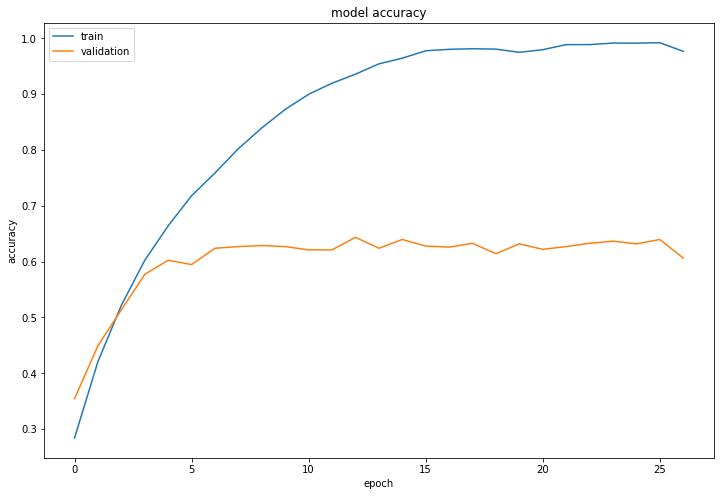

In [14]:
%matplotlib inline
plot_keras_model_learning_curve(model_lstm.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.70      0.46      0.55        35
          1       0.00      0.00      0.00         4
          2       0.67      0.40      0.50         5
          3       0.00      0.00      0.00         1
          4       0.62      0.73      0.67        11
          5       0.55      0.33      0.41        18
          6       0.33      0.25      0.29         4
          7       0.00      0.00      0.00         1
          8       0.81      0.68      0.74        25
          9       0.60      0.43      0.50         7
         10       0.44      0.33      0.38        12
         11       0.28      0.33      0.31        27
         12       0.16      0.50      0.24         6
         13       0.38      0.50      0.43        12
         14       0.31      0.48      0.38        42
         15       0.67      0.50      0.57         4
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00   

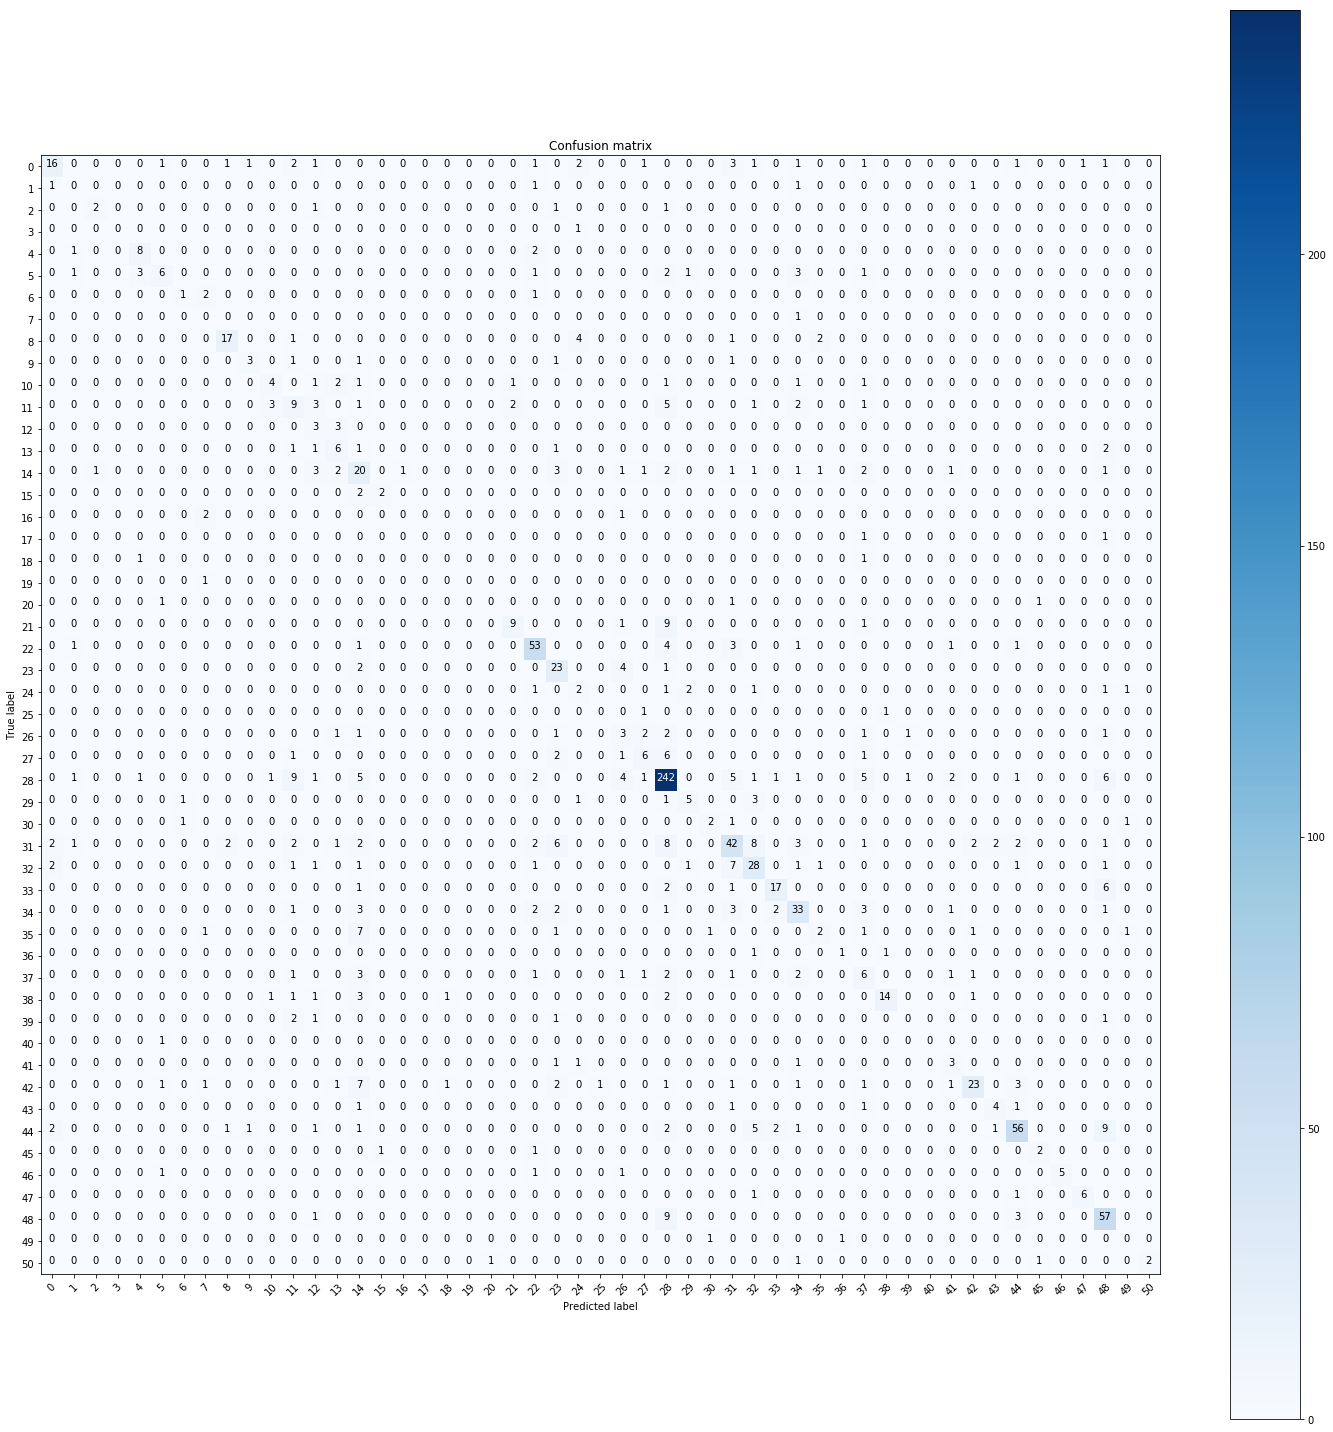

In [16]:
import sklearn
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model_lstm.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()
